In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, train
# from xgboost.sklearn import XGBClassifier
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
train = pd.read_csv('train.csv')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018800,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,low_normal,0.0,NaN,NaN,0.0,-606.0,179055.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.0,0.000,0.0000,0.0,0.0,0.0,-13.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,low_normal,1.0,NaN,NaN,-135882.0,-828.0,348637.5,-746.0,1035882.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-536.0,0.000,0.0000,0.0,0.0,0.0,-23.0,0.0,0.0,-66.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010030,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,middle,0.0,NaN,NaN,4176.0,-815.0,20106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-724.0,0.000,0.0000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008020,-19005,-3039,-9830.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,XNA,0.0,NaN,NaN,0.0,-311.0,267930.0,-181.0,675000.0,-181.0,270000.0,-1.0,0.0,-2.0,0.0,-5.0,NaN,NaN,NaN,1.0,0.0,0.0,-11.0,0.000,0.0000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028660,-19932,-3038,-4310.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,middle,1.0,NaN,NaN,-26788.5,-1768.0,30663.0,-374.0,274288.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,29857.365,452.3843,0.0,16.0,0.0,-3.0,0.0,0.0,-9.0,0.0,0.0,-10.0,0.0,0.0,-35.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Una

In [40]:
corr = train.corr()
corr

In [41]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

In [42]:
train = train.drop(to_drop, axis=1)

In [43]:
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [44]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [45]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [46]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_3        -0.178918
EXT_SOURCE_2        -0.160471
EXT_SOURCE_1        -0.155318
ratio_approved      -0.064367
Days_employed_age   -0.055310
FLOORSMAX_AVG       -0.044003
FLOORSMAX_MEDI      -0.043768
FLOORSMAX_MODE      -0.043226
STATUS_0            -0.039693
AMT_GOODS_PRICE     -0.039645
Name: TARGET, dtype: float64

In [47]:
corr.dropna().tail(10)

REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
CREDIT_ACTIVE_sum              0.061165
DAYS_CREDIT1                   0.064195
DAYS_EMPLOYED                  0.070075
DAYS_CREDIT2                   0.076813
DAYS_BIRTH                     0.078239
ratio_refused                  0.085185
DAYS_CREDIT3                   0.086596
TARGET                         1.000000
Name: TARGET, dtype: float64

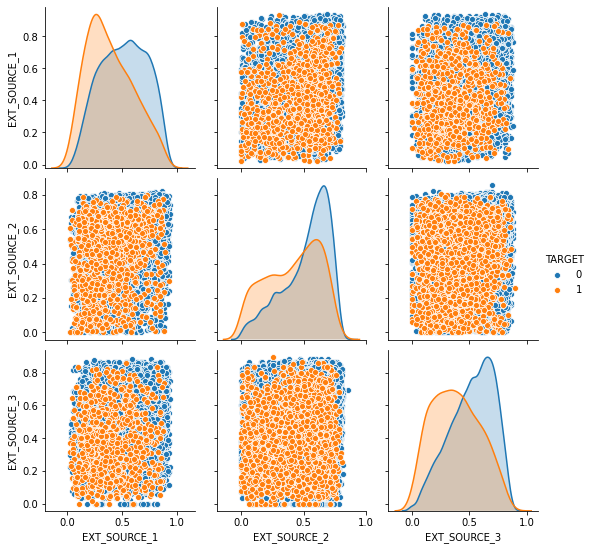

In [48]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

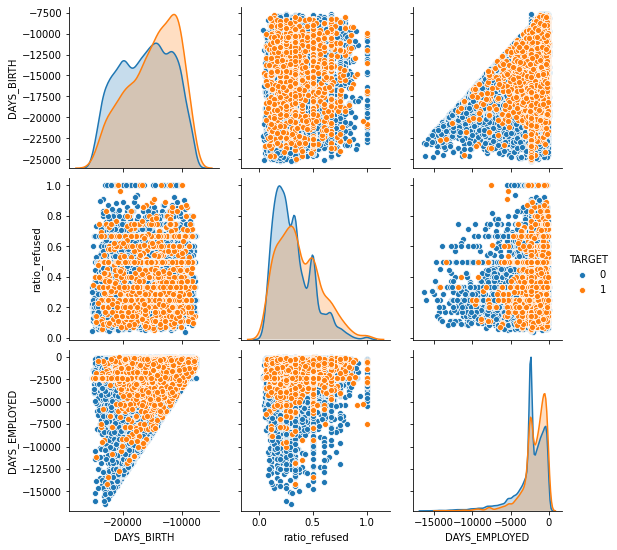

In [49]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [50]:
# train['TARGET'].value_counts()/len(train)

In [51]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [52]:
# # LightGBM offers good accuracy with integer-encoded categorical features. 
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
cols = X.select_dtypes(include= object).columns
for col in cols:
    X[col] = class_le.fit_transform(X[col].values.astype(str))
    X[col] = X[col].astype('category')

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=1234)
pipeline = make_pipeline(StandardScaler(), LGBMClassifier()) # PCA(n_components = 175)
params = {
    'lgbmclassifier__num_leaves' : [100], # value < 2^max depth theoritically default is 100
     # 'lgbmclassifier__min_data_in_leaf': [100], #default is 20 is used to prevent
    'lgbmclassifier__learning_rate': [0.05], #[0.01, 0.05, 0.1]
     # 'lgbmclassifier__max_depth' : [3, 5, 7]
}
model = RandomizedSearchCV(pipeline, params, n_iter=1,  scoring='roc_auc', cv=5, n_jobs=-1, verbose = 3)
model.fit(X_train, y_train)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


0.7684094680298525

In [54]:
model.best_params_

{'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__num_leaves': 100}

In [55]:
from sklearn.metrics import accuracy_score
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] 
print('LGBoost AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)

LGBoost AUC 0.7807215007585179


In [56]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [57]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# print( confusion_matrix(y_test, pred_class) )
# cm = confusion_matrix(y_test, pred_class)
pred_class_2 = (np.array(pred) > 0.1).astype(int)
print(confusion_matrix(y_test, pred_class_2))
cm = confusion_matrix(y_test, pred_class_2)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[44671 11898]
 [ 1875  3059]]
Precision: 0.20451962291903455
Recall 0.6199837859748683


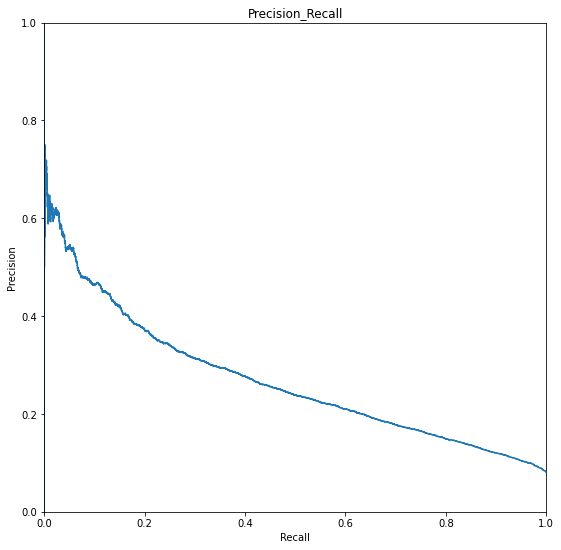

In [58]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [59]:
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,1.743008
1,0.000000,0.000000,inf,0.743008
2,0.000000,0.000000,inf,0.718499
3,0.945048,0.000608,5.985833e+04,0.692895
4,0.919776,0.000608,4.100200e+04,0.687058
...,...,...,...,...
8082,0.503536,0.999595,4.030119e+00,0.014274
8083,0.503586,0.999797,4.029714e+00,0.014269
8084,0.501777,0.999797,4.015079e+00,0.013235
8085,0.501827,1.000000,4.014673e+00,0.013235


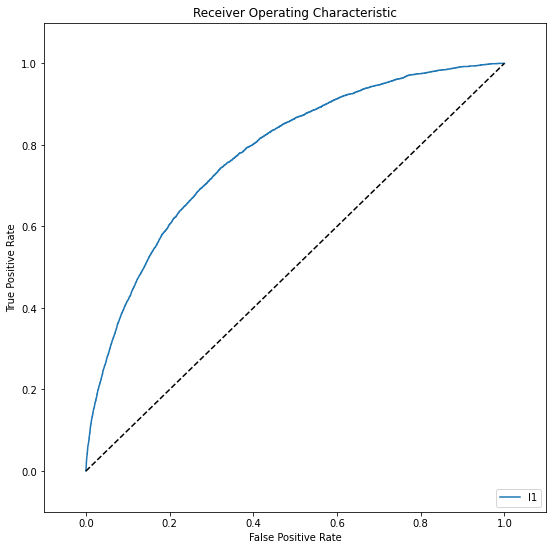

In [60]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
# AUROC
roc_auc_score(y_test, pred)

0.7807215007585179

In [62]:
pred_class_v2 = (np.array(pred) > 0.2).astype(int)
cohen_kappa = cohen_kappa_score(y_test, pred_class_v2)
cohen_kappa

0.24833807988236645